In [1]:
import os
import sys
project_dir = os.path.abspath('../')
sys.path.append(project_dir)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np
from envs import CartPoleSwingUpWarpEnv
env = CartPoleSwingUpWarpEnv(num_envs=1)

Using cached kernels


/home/ksrini/.pyenv/versions/miniconda3-latest/envs/shac/lib/python3.8/site-packages/networkx/classes/graph.py:23: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/home/ksrini/.pyenv/versions/miniconda3-latest/envs/shac/lib/python3.8/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, Set, Iterable
/home/ksrini/.pyenv/versions/miniconda3-latest/envs/shac/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.in

Warp initialized:
   Version: 0.4.3
   Devices:
     "cpu"    | x86_64
     "cuda:0" | NVIDIA GeForce RTX 3090
   Kernel cache: /home/ksrini/.cache/warp/0.4.3


/home/ksrini/.pyenv/versions/miniconda3-latest/envs/shac/lib/python3.8/site-packages/urdfpy/urdf.py:898: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  value = np.asanyarray(value).astype(np.float)


In [56]:
env.model.body_q.numpy()

array([[0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [61]:
import torch
import warp as wp
from utils.warp_utils import float_assign, float_assign_joint_act

class IntegratorSimulate(torch.autograd.Function):
    @staticmethod
    def forward(
        ctx,
        model,
        state_in,
        integrator,
        sim_dt,
        act,
        joint_q_start,
        joint_qd_start,
    ):
        ctx.tape = wp.Tape()
        ctx.model = model
        ctx.act = wp.from_torch(act)
        ctx.joint_q_start = wp.from_torch(joint_q_start)
        ctx.joint_qd_start = wp.from_torch(joint_qd_start)

        ctx.joint_q_end = wp.zeros_like(model.joint_q)
        ctx.joint_qd_end = wp.zeros_like(model.joint_qd)

        # record gradients for act, joint_q, and joint_qd
        ctx.act.requires_grad = True
        ctx.joint_q_start.requires_grad = True
        ctx.joint_qd_start.requires_grad = True
        ctx.joint_q_end.requires_grad = True
        ctx.joint_qd_end.requires_grad = True

        ctx.model.shape_materials.ke.requires_grad = True
        ctx.model.shape_materials.kd.requires_grad = True
        ctx.model.shape_materials.kf.requires_grad = True
        ctx.model.shape_materials.mu.requires_grad = True
        ctx.model.shape_materials.restitution.requires_grad = True 
        ctx.state_out = ctx.model.state(requires_grad=True)

        with ctx.tape:
            float_assign_joint_act(ctx.model.joint_act, ctx.act)
            # updates joint_q joint_qd
            float_assign(ctx.model.joint_q, ctx.joint_q_start)
            float_assign(ctx.model.joint_qd, ctx.joint_q_start)
            body_before = state_in.body_q.numpy().copy()[:3]
            wp.sim.eval_fk(
                ctx.model, ctx.joint_q_start, ctx.joint_qd_start, None, state_in
            )
            body_after = state_in.body_q.numpy().copy()[:3]
            # print("state_in.body_q after eval_fk:\n", state_in.body_q)
            state_in.clear_forces()
            ctx.state_out = integrator.simulate(ctx.model, state_in, ctx.state_out, sim_dt)
            body_after_sim = ctx.state_out.body_q.numpy().copy()[:3]
            wp.sim.eval_ik(ctx.model, ctx.state_out, ctx.joint_q_end, ctx.joint_qd_end)
        return (
            wp.to_torch(ctx.joint_q_end),
            wp.to_torch(ctx.joint_qd_end),
            ctx.state_out,
            body_before, body_after, body_after_sim
        )

    @staticmethod
    def backward(ctx, adj_joint_q, adj_joint_qd, _s0, _b1, _b2, _b3):

        # map incoming Torch grads to our output variables
        ctx.joint_q_end.grad = wp.from_torch(adj_joint_q)
        ctx.joint_qd_end.grad = wp.from_torch(adj_joint_qd)

        ctx.tape.backward()
        joint_act_grad = wp.to_torch(ctx.tape.gradients[ctx.act]).clone()
        joint_q_grad = wp.to_torch(ctx.tape.gradients[ctx.joint_q_start]).clone()
        joint_qd_grad = wp.to_torch(ctx.tape.gradients[ctx.joint_qd_start]).clone()
        print(f"joint_act_grad, {joint_act_grad}")
        print(f"joint_q_grad, {joint_q_grad}")
        print(f"joint_qd_grad, {joint_qd_grad}")
        
        ctx.tape.zero()
        # return adjoint w.r.t. inputs
        return (
            None,
            None,
            None,
            None,
            joint_act_grad,
            joint_q_grad,
            joint_qd_grad,
        )


def warp_step(model, state, joint_q, joint_qd, integrator, actions, sim_dt=1/60, sim_substeps=4, num_envs=1, action_strength=1000):
    with wp.ScopedTimer("simulate", active=False, detailed=False):
        actions = torch.clip(actions, -1.0, 1.0)
        actions = actions.view(num_envs, -1)
        joint_act = action_strength * actions
        bodies = []
        for _ in range(sim_substeps):
            joint_q, joint_qd, state, body_before, body_after, body_after_sim = IntegratorSimulate.apply(
                model,
                state,
                integrator,
                sim_dt/sim_substeps,
                joint_act,
                joint_q,  # cut off grad to prev timestep?
                joint_qd,  # cut off grad to prev timestep?
            )
            bodies.append((body_before, body_after, body_after_sim))
    reward = calculateReward(joint_q, joint_qd, actions)
    return state, joint_q, joint_qd, reward, bodies
    
@torch.jit.script
def normalize_angle(x):
    return torch.atan2(torch.sin(x), torch.cos(x))

    
def calculateReward(joint_q, joint_qd, actions):
    joint_q = joint_q.view(1, -1)
    joint_qd = joint_qd.view(1, -1)

    x = joint_q[:, 0]
    theta = normalize_angle(joint_q[:, 1])
    xdot = joint_qd[:, 0]
    theta_dot = joint_qd[:, 1]

    rew_buf = (
        -torch.pow(theta, 2.0) * 1.
        - torch.pow(theta_dot, 2.0) * 0.1
        - torch.pow(x, 2.0) * 0.05
        - torch.pow(xdot, 2.0) * 0.1
        - torch.sum(actions**2, dim=-1) * 0.0
    )
    return rew_buf

In [22]:
def test_fn(actions, plot=False):
    ob_vec = []
    ob_vec.append(env.reset().detach().cpu().numpy().flatten())
    for _ in range(20):
        obs, reward, done, info = env.step(actions)
        ob_vec.append(obs.detach().cpu().numpy().flatten())
    if plot:
        ob_vec = np.array(ob_vec)
        fig, axs = plt.subplots(nrows=1, ncols=ob_vec.shape[1], figsize=(3*ob_vec.shape[1], 4))
        for i in range(ob_vec.shape[1]):
            axs[i].plot(ob_vec[:, i])
            axs[i].grid()
        plt.suptitle('without IK')
        plt.show()
    return reward


def check_grad(fn, inputs, eps=1e-6, atol=1e-4, rtol=1e-6):
    out = fn(inputs)
    out.backward()
    analytical = inputs.grad.clone()
    x2, x1 = inputs + eps, inputs - eps
    numerical = (fn(x2) - fn(x1)) / (2 * eps)
    assert torch.allclose(numerical, analytical, rtol, atol), "numerical gradient was: {}, analytical was: {}".format(numerical, analytical)
    return (numerical, analytical)

In [62]:
env.reset().detach().cpu().numpy().flatten()
model, integrator = env.model, env.integrator
state = env.state
joint_q, joint_qd = env.joint_q, env.joint_qd
bodies_before, bodies_after, bodies_after_sim = [], [], []
actions = torch.tensor([[0.]], dtype=torch.float32, device='cuda', requires_grad=True)

for _ in range(20):
    state, joint_q, joint_qd, reward, bodies = warp_step(model, state, joint_q, joint_qd, integrator, actions, num_envs=env.num_envs)
    bodies_before.append([x[0] for x in bodies])
    bodies_after.append([x[1] for x in bodies])
    bodies_after_sim.append([x[2] for x in bodies])


In [63]:
bodies_before = np.concatenate(bodies_before)
bodies_after = np.concatenate(bodies_after)
bodies_after_sim = np.concatenate(bodies_after_sim)

In [64]:
bodies_before.shape

(80, 3, 7)

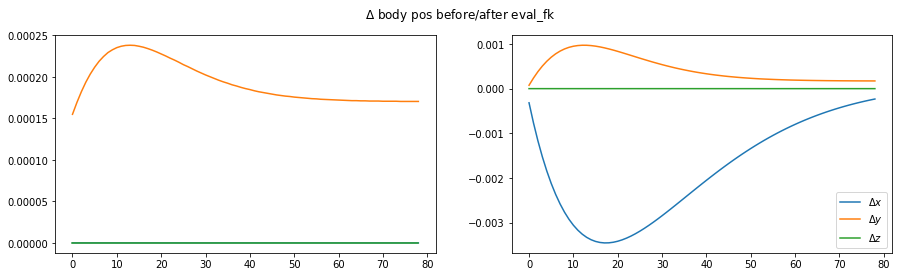

In [69]:
f, ax = plt.subplots(ncols=2, figsize=(15, 4))
for i in range(1,3):
    ax[i-1].plot(bodies_after[1:, i, :3] - bodies_before[1:, i, :3])
plt.suptitle("$\Delta$ body pos before/after eval_fk")
plt.legend(['$\Delta x$', '$\Delta y$', '$\Delta z$'])
plt.show()

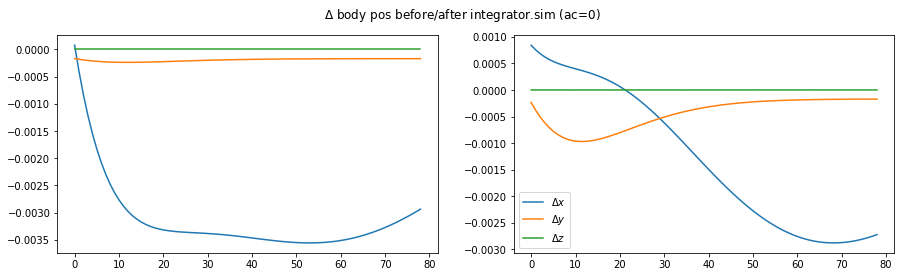

In [68]:
f, ax = plt.subplots(ncols=2, figsize=(15, 4))
for i in range(1, 3):
    ax[i-1].plot(bodies_after_sim[1:, i, :3] - bodies_after[1:, i, :3])
plt.suptitle("$\Delta$ body pos before/after integrator.sim (ac=0)")
plt.legend(['$\Delta x$', '$\Delta y$', '$\Delta z$'])
plt.show()

Module utils.warp_utils load on device 'cuda:0' took 0.35 ms
Module warp.sim.articulation load on device 'cuda:0' took 0.80 ms
Module warp.sim.integrator_euler load on device 'cuda:0' took 1.88 ms


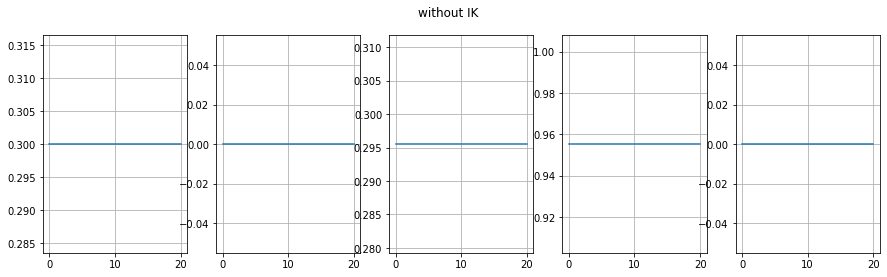

tensor([-0.0945], device='cuda:0', grad_fn=<SubBackward0>)

In [5]:
action = torch.zeros((env.num_envs, env.num_actions), requires_grad=True, device='cuda')
test_fn(action, plot=True)

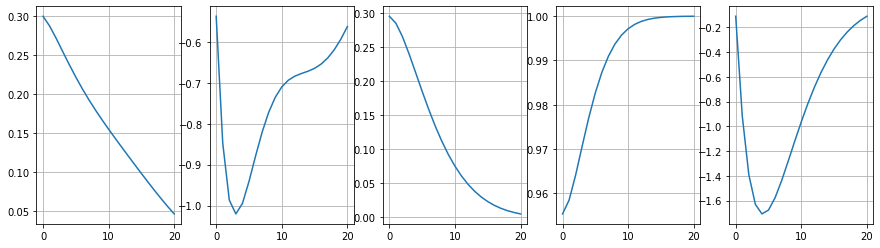

tensor([-0.0330], device='cuda:0', grad_fn=<SubBackward0>)

In [11]:
action = torch.zeros((env.num_envs, env.num_actions), requires_grad=True, device='cuda')
test_fn(action, plot=True)

In [17]:
obs = env.reset()

env.step(action)

(tensor([[ 0.0000e+00,  0.0000e+00,  8.7423e-08, -1.0000e+00,  0.0000e+00]],
        device='cuda:0', grad_fn=<CatBackward0>),
 tensor([-9.8696], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([0], device='cuda:0'),
 {})

In [14]:
action = torch.zeros((env.num_envs, env.num_actions), requires_grad=True, device='cuda')
a2 = torch.tensor([[0.5]], requires_grad=True, device='cuda')
a2 = torch.tensor([[0.75]], requires_grad=True, device='cuda')

In [16]:
test_fn(a2)

tensor([-9.8696], device='cuda:0', grad_fn=<SubBackward0>)

In [15]:
check_grad(test_fn, a2)

(tensor([0.], device='cuda:0', grad_fn=<DivBackward0>),
 tensor([[0.]], device='cuda:0'))

In [17]:
rew = test_fn(action)

particle_q
particle_qd
particle_mass
particle_inv_mass
shape_geo_scale
shape_contact_thickness
spring_rest_length
spring_stiffness
spring_damping
spring_control
tri_activations
tri_materials
edge_rest_angle
edge_bending_properties
tet_activations
tet_materials
body_com
joint_axis
joint_armature
joint_target_ke
joint_target_kd
joint_target
joint_linear_compliance
joint_angular_compliance
joint_limit_lower
joint_limit_upper
particle_q_original
muscle_params
muscle_points
muscle_activation
body_mass
body_inv_mass
joint_limit_ke
joint_limit_kd
soft_contact_body_pos
soft_contact_body_vel
soft_contact_normal
rigid_contact_point0
rigid_contact_point1
rigid_contact_offset0
rigid_contact_offset1
rigid_contact_normal
rigid_contact_thickness
rigid_active_contact_point0
rigid_active_contact_point1
rigid_active_contact_distance
rigid_active_contact_distance_prev
rigid_contact_inv_weight


tensor([-11.4972], device='cuda:0', grad_fn=<SubBackward0>)

In [18]:
Out[17].backward()

In [25]:
model_vars = """particle_q
particle_qd
particle_mass
particle_inv_mass
shape_geo_scale
shape_contact_thickness
spring_rest_length
spring_stiffness
spring_damping
spring_control
tri_activations
tri_materials
edge_rest_angle
edge_bending_properties
tet_activations
tet_materials
body_com
joint_axis
joint_armature
joint_target_ke
joint_target_kd
joint_target
joint_linear_compliance
joint_angular_compliance
joint_limit_lower
joint_limit_upper
particle_q_original
muscle_params
muscle_points
muscle_activation
body_mass
body_inv_mass
joint_limit_ke
joint_limit_kd
soft_contact_body_pos
soft_contact_body_vel
soft_contact_normal
rigid_contact_point0
rigid_contact_point1
rigid_contact_offset0
rigid_contact_offset1
rigid_contact_normal
rigid_contact_thickness
rigid_active_contact_point0
rigid_active_contact_point1
rigid_active_contact_distance
rigid_active_contact_distance_prev
rigid_contact_inv_weight""".split("\n")

In [ ]:
for var in model_vars:
    if getattr(env.model, var)

In [21]:
env.state.body_f.grad.numpy()

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)